In [1]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from dhg import Graph
from dhg.data import Cora
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

In [2]:
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

Epoch: 0, Time: 0.18135s, Loss: 1.95030
update best: 0.31600
Epoch: 1, Time: 0.01158s, Loss: 1.94620
Epoch: 2, Time: 0.01280s, Loss: 1.94386
Epoch: 3, Time: 0.01137s, Loss: 1.93975
Epoch: 4, Time: 0.01183s, Loss: 1.93413
update best: 0.36800
Epoch: 5, Time: 0.01412s, Loss: 1.92864
Epoch: 6, Time: 0.01308s, Loss: 1.92434
Epoch: 7, Time: 0.01206s, Loss: 1.91881
Epoch: 8, Time: 0.01251s, Loss: 1.91109
Epoch: 9, Time: 0.01151s, Loss: 1.90360
Epoch: 10, Time: 0.01494s, Loss: 1.90063
Epoch: 11, Time: 0.01306s, Loss: 1.88857
Epoch: 12, Time: 0.01247s, Loss: 1.88073
Epoch: 13, Time: 0.01223s, Loss: 1.87651
Epoch: 14, Time: 0.01306s, Loss: 1.86387
Epoch: 15, Time: 0.01279s, Loss: 1.85570
Epoch: 16, Time: 0.01321s, Loss: 1.84182
Epoch: 17, Time: 0.01208s, Loss: 1.83335
Epoch: 18, Time: 0.01411s, Loss: 1.82505
Epoch: 19, Time: 0.01422s, Loss: 1.79822
update best: 0.37400
Epoch: 20, Time: 0.01592s, Loss: 1.79343
update best: 0.38800
Epoch: 21, Time: 0.01508s, Loss: 1.78278
update best: 0.39600
Epo

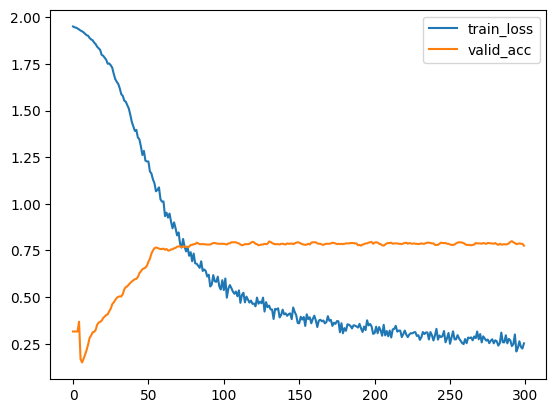

In [3]:
set_seed(2022)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
data = Cora()
X, lbl = data["features"], data["labels"]

G = Graph(data["num_vertices"], data["edge_list"])
train_mask = data["train_mask"]
val_mask = data["val_mask"]
test_mask = data["test_mask"]

net = GCN(data["dim_features"], 16, data["num_classes"])
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

X, lbl = X.to(device), lbl.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
train_loss = []
valid_acc = []
for epoch in range(300):
    # train
    loss = train(net, X, G, lbl, train_mask, optimizer, epoch)
    train_loss.append(loss)
    # validation
    if epoch % 1 == 0:
        with torch.no_grad():
            val_res = infer(net, X, G, lbl, val_mask)
            valid_acc.append(val_res)
        if val_res > best_val:
            print(f"update best: {val_res:.5f}")
            best_epoch = epoch
            best_val = val_res
            best_state = deepcopy(net.state_dict())
print("\ntrain finished!")
print(f"best val: {best_val:.5f}")
# test
print("test...")
net.load_state_dict(best_state)
res = infer(net, X, G, lbl, test_mask, test=True)
print(f"final result: epoch: {best_epoch}")
print(res)

plt.plot(range(300), train_loss)
plt.plot(range(300), valid_acc)
plt.legend(['train_loss', 'valid_acc'])
plt.show()